Here we extract the subset of the whole dataset. We run over several hyperparameters: 
1. the amount of genes to consider for scVelo
2. mixing the pseudotime kernel with the Velocity kernel ratio


we run the main cell developement line idenfied in chan et al (https://doi.org/10.1101/2023.07.31.551262) using the velocity


In [ ]:
import pandas as pd ## importsb
import seaborn as sns
import numpy as np
import glob
import os
import random
import scipy
import matplotlib.pyplot as plt
import scvelo as scv
import networkx as nx
import anndata as ad
import cellrank as cr
import scanpy as sc

from matplotlib.patches import Rectangle


import os


In [ ]:
##uncomment for real data (clster)
#path_main = "/home/wchan210"
#path_plot = path_main + '/plots/'

##uncomment for toy data set - sam's mac
path_main = "../.."
path_plot = path_main + '/plots/'


# Check if path exists or not
isExist = os.path.exists(path_plot)
#printing if the path exists or not
print(isExist)

if not isExist:
    os.makedirs(path_plot) ##make the path where to save plots
    print(path_plot)




## 1. load in the datasets take the subsets

In [ ]:
##uncomment for real data (clster)
#wt_all =scv.read(path_main + '/CellRank/chan_wt_dynamic.h5ad') ##replace with wt all genes path 
#mut_all =scv.read(path_main + '/CellRank/chan_mut_dynamical.h5ad') ##replace with mut all genes path 

##uncomment for toy data set
wt_all =scv.read(path_main + '/labelled/all_info/chan_wt_dynamical_trimmed_with_PAX6.h5ad') ##replace with wt all genes path 
mut_all =scv.read(path_main + '/labelled/all_info/chan_mut_dynamical_trimmed_with_PAX6.h5ad') ##replace with mut all genes path 


pathway1_cells = ['RGP1','RGP2','RGP3','IN1','IP','EN','DLN','SLN','IN Progenitor'] #set the clusters included in the analysis

wt_path1 = wt_all[wt_all.obs.cluster.isin(pathway1_cells)]#.copy()
mut_path1 = mut_all[mut_all.obs.cluster.isin(pathway1_cells)]#.copy()




subset_names = ['wt','mut']
subsets = [wt_path1,mut_path1]
datasets = dict(zip(subset_names, subsets))
#mut_all = scv.read('../../labelled/all_info/chan_wt.h5ad')



In [ ]:
#mut_all[mut_all.obs.cluster.isin(pathway1_cells)] #subset the cells
##have a look at the clusters still included in the dataset

with scv.GridSpec(ncols=2) as pl: ##check the subsets
    pl.scatter(datasets['mut'], color = 'cluster', color_map ='gnuplot', title='mut path 1')
    pl.scatter(datasets['wt'], color = 'cluster', color_map='gnuplot', title='wt path 2')
#pathway1_cells = ['RGP1','RGP2','RGP3','IN Progenitor','IN1','IP','EN','DLN','SLN']



In [ ]:
##dont run

top_genes = datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(datasets['mut'], basis=top_genes[:15], color = 'cluster',ncols=5, frameon=False)




scv.pl.scatter(datasets['mut'], basis=top_genes[:15], color = 'cluster',ncols=5, frameon=False)



In [ ]:
##dont run

top_genes = datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index[:20]
scv.pl.heatmap(datasets['mut'], var_names=top_genes, sortby='latent_time', col_color='cluster', n_convolve=100)

## 2. calculate the dynamics of the subset

Here we find the driver genes using sc velo only and save the figures. (use these figures to analyse kinetics of the highest likelihood genes - can we see various kinetics)

In the future it might be useful to subset the DLN track of the mutant - compare the gene expression across the latent time

## 3. use cell rank to calculate cell fates and so on

since the last round we ran with 2000 top genes -- that is the data we are working here with now

We build up the 'kernels' (term used for matrices in the cellrank documentation) from the latent time (velocity latent time/pseudotime) and velocity we calcaulted earlier. 


In [ ]:
estimators = {}

for mut_wt in datasets:
    ##find the connectivity graph (once again - done in scvelo before, combine wiht connectivity kernel)


    print(mut_wt)
    dataset = datasets[mut_wt]

    vk = cr.kernels.VelocityKernel(dataset)
    vk.compute_transition_matrix()

    ck = cr.kernels.ConnectivityKernel(dataset)
    ck.compute_transition_matrix()

    combined_kernel = 0.8 * vk + 0.2 * ck

    combined_kernel.plot_projection(color = 'cluster')

    combined_kernel.plot_random_walks(start_ixs={"cluster": "RGP1"}, max_iter=100, seed=0,save = path_plot + f'{mut_wt}_random_walks_100_steps_.png', color="cluster")

    ##pseudotime

    pk = cr.kernels.PseudotimeKernel(dataset, time_key="dpt_pseudotime")
    pk.compute_transition_matrix()

    pk.plot_projection(recompute=True,save = path_plot + f'{mut_wt}_pseudotime_cellrank_embedding.png', color = 'cluster')

    #plots only the peseudotime with streamlines
    

    ##estimate the end and starting points
    estimator =  cr.estimators.GPCCA(combined_kernel) ##use the combined kernel to compute the macrostates 

    estimator.fit(cluster_key="cluster", n_states= [4,8]) ##fit between four and eight states

    estimator.plot_macrostates(which="all", discrete=True, legend_loc="right") ##plot the states found

    estimator.predict_terminal_states(allow_overlap=True) ##predict the terminal states
    estimator.predict_initial_states(allow_overlap=True)  ##predict the initial states

    estimator.plot_macrostates(which="initial", discrete=True,legend_loc="right" ,save = path_plot + f'{mut_wt}_initial_states_auto.png') ##plot initial
    estimator.plot_macrostates(which="terminal",discrete=True, legend_loc="right",save = path_plot + f'{mut_wt}_terminal_states_auto.png')


    estimator.compute_fate_probabilities()

    estimator.plot_fate_probabilities(same_plot=False,dpi = 300,save = path_plot + f'{mut_wt}_cell_fates_combined_kernel.png')


    estimatorPK =  cr.estimators.GPCCA(pk) ##use the pesudotime kernel to compute the macrostates

    estimatorPK.fit(cluster_key="cluster", n_states= [4,7])
    estimatorPK.plot_macrostates(which="all", discrete=True, legend_loc="right")

    estimatorPK.plot_macrostates(which="all", discrete=True, legend_loc="right") ##plot the results

    estimatorPK.predict_terminal_states(allow_overlap=True)
    estimatorPK.predict_initial_states(allow_overlap=True)

    estimatorPK.plot_macrostates(which="initial", discrete=True,legend_loc="right" ,save = path_plot + f'{mut_wt}_pseudotime_initial_states_auto.png') ##plot initial
    estimatorPK.plot_macrostates(which="terminal",discrete=True, legend_loc="right",save = path_plot + f'{mut_wt}_Pseudotime_terminal_states_auto.png')


    estimatorPK.compute_fate_probabilities()

    estimatorPK.plot_fate_probabilities(same_plot=False,dpi = 300,save = path_plot + f'{mut_wt}_cell_fates_pseudotime_kernel.png')

    dataset.write(path_main + f'/{mut_wt}_all_genes_pseudotime_velocity_latent_times.h5ad', compression="gzip")

    estimators[mut_wt] = estimator
    estimators[f'{mut_wt}_PK'] = estimatorPK
    
    











## 3. build the kernels and transition probability graphs

## 4. calculate the driver genes for each cell fate

In [ ]:
for cond in estimators:
    estimator = estimators[cond]

    driver_clusters = ['RGP1', 'RGP2', 'RGP3', 'IP']

    if cond == ('mut'):

        
        drivers_df = estimator.compute_lineage_drivers(
            lineages=["DLN","IN1_2"], cluster_key = 'cluster', clusters = driver_clusters
        )
    if cond == 'mut_PK':

        drivers_df = estimator.compute_lineage_drivers(
            lineages=["DLN_1","IN1_2",'DLN_2','IN1_1'], cluster_key = 'cluster', clusters = driver_clusters
        )
        
    else:
        drivers_df = estimator.compute_lineage_drivers(
            lineages=["DLN"], cluster_key = 'cluster', clusters = driver_clusters
        )

    if 'mut' in cond:
        adata = datasets['mut']

    else:
        adata = datasets['wt']
    if cond == 'mut_PK':

        adata.obs["fate_probabilities_DLN"] = estimator.fate_probabilities["DLN_1"].X.flatten()
    else:
        adata.obs["fate_probabilities_DLN"] = estimator.fate_probabilities["DLN"].X.flatten()

    

    sc.pl.embedding(
            adata,
            basis="umap",
            color=["fate_probabilities_DLN"] + list(drivers_df.index[:8]),
            color_map="viridis",
            s=10,
            ncols=3,
            vmax="p96",
            title = f'{cond}_probability'
            #save = path_plot + 'fate_probabilities_DLN.png'
        )


    

    drivers_df.head()

    drivers_df.to_csv('/home/wchan210/pk_mut_cellfatecorr.csv')
    

In [ ]:
##save the inferred driver genes
drivers_df.to_csv('/home/wchan210/pk_mut_cellfatecorr.csv')

In [ ]:
df_corr = pd.read_csv('/Users/samuelheczko/Downloads/pk_mut_cellfatecorr.csv' ,header=0,index_col = 'Gene')

In [ ]:
df_corr.head()

In [ ]:
#np.corrcoef(df_corr.DLN_1_corr.dropna().values,df_corr.DLN_2_corr.dropna().values)

#plt.scatter(df_corr.DLN_1_corr.dropna().values,df_corr.IN1_2_corr.dropna().values)


(df_corr.DLN_1_corr.dropna() - df_corr.IN1_2_corr.dropna()).abs().nlargest(10)






In [ ]:
ip_genes = mut_all[mut_all.obs.cluster == 'IP'].var.fit_likelihood.sort_values(ascending = False).index

#datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index

## 5. looking at the wt small subsets (copy paste from here)

In this part we build pipline to subset a region in dataset using cluster ids and select rectangular regions within the UMAP embedding. For our data we have identified a 'bridge' which point for our data is to look at the IP cells which turn around from the path which in the mutant leads to inhibiotory tract.

In [ ]:
##we start by subsetting the data
ips_mut = mut_all[mut_all.obs.cluster == 'IP'].copy()
ips_wt = wt_all[wt_all.obs.cluster == 'IP'].copy()

ips_dict = {}
ips_dict['wt'] = ips_wt ##set the subsets as dictionary for easier looping
ips_dict['mut'] = ips_mut


INP_mut = wt_all[wt_all.obs.cluster == 'IN Progenitor'].copy()


overlapping_genes_mut_wt = list(set(INP_mut.var_names) & set(terminal_state1.var_names)) #comment out with all genes




In [ ]:
##define helper function which finds poiutns inisde a rectangle

def points_inside_rectangle(rectangle, points):
    """
    Check which points are inside the given rectangle.

    Parameters:
    - rectangle: Tuple of (x, y, width, height)
    - points: NumPy array of points, each represented as (x, y)

    Returns:
    - NumPy array of points that are inside the rectangle
    """
    x, y, width, height = rectangle

    # Create a bounding box for the rectangle
    rect_x, rect_y = x, y
    rect_width, rect_height = width, height
    rect_corners = np.array([[rect_x, rect_y], [rect_x + rect_width, rect_y + rect_height]])

    # Check which points are inside the bounding box using vectorized operations
    inside_bbox = np.all(points >= rect_corners[0], axis=1) & np.all(points <= rect_corners[1], axis=1)

    # Return the points that are inside the bounding box
    points_inside = points[inside_bbox]

    return points_inside,inside_bbox

def get_rectangle_coords(coords): #x,y,x,y,width,height
    return (coords[0],coords[1],coords[0] + coords[2],coords[1] + coords[3])


## 1a set the boundaries of the subsets studied

Here we set up the boundaries of the rectangles in which we will look at the gene expression and velocity


In [ ]:
##set the square you want to subset

rectangles = {}
rectangle_coords = {}

rectangles['1'] = (-2,3.2,4,0.4) #x,y,width,height - Set here the rectangle limits ##the bridge coordinates
rectangles['2'] = (-6,2.8,3.5,1) ##x,y,width,height - Set here the rectangle 2 limits  ##the DLN pointing pathway 
rectangles['3'] = (2,1.9,1.8,2) ##the IN pointing pathway 
rectangles['4'] = (-1,4,2,2) ##the IN pointing pathway 



rectangle_colors = {'1': 'y', '2': '#9467bd','3' : '#17becf','4' : '#7f7f7f'} ##set the colours

#plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] example colours(chat gpt )


##add more rectangles and colours if needed

for rectangle in rectangles:
    rectangle_coords[rectangle] = get_rectangle_coords(rectangles[rectangle]) ##manipualte then to get the coords
#rectangle_coords_np = np.array([[rectangle_coords[0],rectangle_coords[1]],[rectangle_coords[2],rectangle_coords[3]]])

##plot the subset and find the cells in the 'bridge' 
fig, ax = plt.subplots(nrows = 2,sharex=True)
fig.set_figheight(10)
fig.set_figwidth(12)

#rectangle_coords = (rectangle_values[0],rectangle_values[1],rectangle_values[0] + rectangle_values[2],rectangle_values[1] + rectangle_values[3])
#rectangle_coords_np = np.array([[rectangle_coords[0],rectangle_coords[1]],[rectangle_coords[2],rectangle_coords[3]]])

masks_all = {} #intialise dictionary for the index mask containgn the points within the rectangle

for genotype_i, genotype in enumerate(ips_dict):
    masks = {} ##intialise dictionarys to take the different subsets
    inside = {}
    for rectangle in rectangles:
    

        inside[rectangle],bbx = points_inside_rectangle(rectangles[rectangle],ips_dict[genotype].obsm['X_umap'])
        masks[rectangle] = bbx



        ax[genotype_i].set_title(genotype)

        ax[genotype_i].set_ylim((1,6))
        ax[genotype_i].set_xlim((-6,7))


    

        rect = Rectangle((0,1),1,1,fill = False,ls = '--', lw = 2,label = f'subset {rectangle} boundaries',color = rectangle_colors[rectangle]) ##draw the rectangle on the plot
        rect.set_bounds(rectangles[rectangle])
        ax[genotype_i].add_patch(rect)
    
        

        #ax[genotype_i].scatter(inside[:,0],inside[:,1],s = 5.5,color = 'r',label = 'bridge cells')

        

        ax[genotype_i].quiver(ips_dict[genotype].obsm['X_umap'][bbx,0],ips_dict[genotype].obsm['X_umap'][bbx,1],ips_dict[genotype].obsm['velocity_umap'][bbx,0],ips_dict[genotype].obsm['velocity_umap'][bbx,1],label = f'velocity vectors {rectangle}',color = rectangle_colors[rectangle], edgecolor = 'k', linewidth = 0.5,scale = 1.5,width = 0.0025)
    


    arrays_list = list(masks.values())
    result_array = np.any(arrays_list, axis=0) ##take the points which are not in any of the rectangles
    sum_ = result_array
    masks['and'] = result_array
    ax[genotype_i].quiver(ips_dict[genotype].obsm['X_umap'][~sum_,0],ips_dict[genotype].obsm['X_umap'][~sum_,1],ips_dict[genotype].obsm['velocity_umap'][~sum_,0],ips_dict[genotype].obsm['velocity_umap'][~sum_,1],label = 'velocity vecotors', color = '#8c564b',edgecolor = 'k', linewidth = 0.6,scale = 1.7)
    
    handles, labels = ax[genotype_i].get_legend_handles_labels()

    # Change the order of handles and labels
    new_order =   list(np.roll(np.arange(len(labels)), shift=1)) # Change the order as needed
    handles = [handles[i] for i in new_order]
    labels = [labels[i] for i in new_order]
    print(labels)

    ax[genotype_i].legend(handles,labels)

    masks_all[genotype] = masks

In [ ]:

## add the subset labels to the dataset

ips_dict['wt'].obs['subset'] = None
ips_dict['wt'].obs['subset'][masks_all['wt']['1']] = 'bridge'
ips_dict['wt'].obs['subset'][masks_all['wt']['2']] = 'DLN'
ips_dict['wt'].obs['subset'][masks_all['wt']['3']] = 'terminal'
ips_dict['wt'].obs['subset'][masks_all['wt']['4']] = 'start'


ips_dict['wt'].obs['subset']

#sc.pl.embedding(ips_dict['wt'][ips_dict['wt'].obs.bridge == True],basis='umap')


In [ ]:
#calcuate the t tests - save plots
sc._settings.ScanpyConfig(figdir=path_plot)
sc.set_figure_params(dpi=80,dpi_save=200)

sc.tl.rank_genes_groups(ips_dict['wt'], 'subset', method='t-test',reference = 'terminal')
sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False)
#
df_tvalues_start_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'start')
df_tvalues_DLN_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'DLN')
df_tvalues_bridge_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'bridge')

df_tvalues_bridge_v_term.to_csv(path_main + '/data/brdige_v_term.csv')
df_tvalues_DLN_v_term.to_csv(path_main + '/data/DLN_v_term.csv')
df_tvalues_start_v_term.to_csv(path_main + '/data/start_v_term.csv')







#DLN




In [ ]:
list(set(df_tvalues_DLN_v_term.nsmallest(200,'scores').names.values) & set(df_tvalues_start_v_term.nlargest(200,'scores').names.values))


list(set(df_tvalues_DLN_v_term.nlargest(150,'scores').names.values) & set(df_tvalues_start_v_term.nsmallest(150,'scores').names.values))



In [ ]:
ips_dict['genotype'].obsm

In [ ]:
ips_dict['wt'].uns['rank_genes_groups']

In [ ]:
##find the gene lists - total six of them - the highest velocity and expression in the rectangle, highly outside the rectangle, high differenece and same for velocity
sc.set_figure_params(dpi=80,dpi_save=200)
how_many = 21 ##how many genes to examine

gene_vel_dict = {} ##intialise dictiornary for velocities

gene_vel_dict['bridge'] = ips_wt.layers['velocity'][masks['wt'],:].mean(axis = 0) ##find the mean velocity over the cells of each gene - bridge
gene_vel_dict['exlcld_bridge'] = ips_wt.layers['velocity'][~masks['wt'],:].mean(axis = 0) ##find the mean velocity of each gene - excluding
gene_vel_dict['dif'] = gene_vel_dict['bridge'] - gene_vel_dict['exlcld_bridge'] ##find the mean velocity of each gene - difference

gene_exp_dict = {} ##intialise dictiornary for expressions

gene_exp_dict['bridge'] = np.squeeze(np.asarray(ips_wt.X[masks['wt'],:].mean(axis = 0))) ##find the mean expressions of each gene - bridge
gene_exp_dict['exlcld_bridge'] = np.squeeze(np.asarray(ips_wt.X[~masks['wt'],:].mean(axis = 0))) ##find the mean expressions of each gene - excluding bridge
gene_exp_dict['dif'] = gene_exp_dict['bridge'] - gene_exp_dict['exlcld_bridge'] ##find the mean velocity of each gene - difference

genes_top_vel = {}

genes_top_exp = {}


for cond in gene_vel_dict:
    plt.figure(dpi=300)
    print(cond + ' VELOCITY')

    ind = np.argpartition(abs(gene_vel_dict[cond]), -how_many)[-how_many:]
    print(gene_vel_dict[cond][ind])
    genes_top_vel[cond]  = ips_wt.var.index[ind] ##find the names of the top genes founf from the array

    print(genes_top_vel[cond]) ##print the names

    sc.pl.embedding(
        wt_all,
        basis="umap",
        color=genes_top_vel[cond],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        title = zip(genes_top_vel[cond], gene_vel_dict[cond][ind]),
        save = f'top_genes_{cond}_velocity.pdf'
    )


    plt.show()



    print(cond + ' EXPRESSION')
    ind = np.argpartition(abs(gene_exp_dict[cond]), -how_many)[-how_many:] ##find the indecies of the average top genes
    print(gene_exp_dict[cond][ind])
    genes_top_exp[cond]  = ips_wt.var.index[ind] ##look up the names of the genes
    print(genes_top_exp[cond])




    sc.pl.embedding(
        wt_all,
        basis="umap",
        color=genes_top_exp[cond],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        save = f'top_genes_{cond}_expression.pdf'
    )


    plt.show()

    #plt.hist(abs(gene_vel_dict[cond]),bins = 20)

In [1000]:
##overlap of 
list(set(genes_top_exp['dif']) & set(genes_top_vel['bridge']))


['CENPF']

In [ ]:
##find genes which are in both top 21 different expression as well as velocity

overlap = list(set(genes_top_exp['dif']) & set(genes_top_vel['dif']))
#print (bool(set(genes_top_exp['dif']) & set(genes_top_vel['dif'])))
print (f'the overlaping genes {overlap}')
overlap.remove('UBE2C')

##plot the overlapping genes expression in mutant UMAP

sc.pl.embedding(
wt_all,
basis="umap",
color=overlap,
color_map="viridis",
s=10,
ncols=3,
vmax="p96",
#title = zip(genes_top_vel[cond], gene_vel_dict[cond][ind]),
save = f'_overlap_genes_wt.pdf'
)




In [ ]:
##plot the velocity fittings of the found overlap in mut and wt - see whetere the velocity is low or high within the subset of 'bridge'

scv.pl.scatter(ips_dict['mut'], basis='CENPF', ncols=5, frameon=False,color = masks['mut'],dpi = 300,title='CENPF_IPs_mutant',colorbar=False)
scv.pl.scatter(ips_dict['wt'], basis='EOMES', ncols=5, frameon=False,color = masks['wt'],dpi = 300,title='EOMES_IPs_wt',colorbar=False)

In [ ]:
genes = ['NFIB','ASPM','NNAT','SYNE2','CNTNAP2','CENPF','EOMES','NEUROD6']#EOMES

sc.pl.embedding(
        wt_all,
        basis="umap",
        color=genes,
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        #title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        #save = f'top_genes_{cond}_expression_nervous_system_development.pdf'
    )

sc.pl.embedding(
        mut_all,
        basis="umap",
        color=['NFIB','ASPM','NNAT','SYNE2','CNTNAP2','CENPF'],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        #title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        #save = f'top_genes_{cond}_expression_nervous_system_development.pdf'
    )

# mutatnt vs wt subset - last analysis 
here we look at how the gene expression

In [1042]:
terminal_state1 = ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal']
bridge = ips_dict['wt'][masks_all['wt']['1']]
end = ips_dict['wt'][masks_all['wt']['2']]

INP_mut = mut_all[mut_all.obs['cluster'] == 'IN Progenitor']

#ips_dict['wt'].obs['subset'][masks_all['wt']['1']] = 'bridge'
#ips_dict['wt'].obs['subset'][masks_all['wt']['2']] = 'DLN'
#ips_dict['wt'].obs['subset'][masks_all['wt']['3']] = 'terminal'
#ips_dict['wt'].obs['subset'][masks_all['wt']['4']] = 'start'


In [1048]:
overlapping_genes = list(set(INP_mut.var_names) & set(end.var_names))


np.corrcoef(terminal_state1[:, overlapping_genes].X.mean(axis = 0),INP_mut[:, overlapping_genes].X.mean(axis = 0))






array([[1.        , 0.96821257],
       [0.96821257, 1.        ]])

In [ ]:
mut_all.obs.cluster

[[1.         0.96821257]
 [0.96821257 1.        ]]


['STXBP6', 'NFIC', 'FYN', 'ELAVL4', 'IGFBPL1', 'ELAVL2']

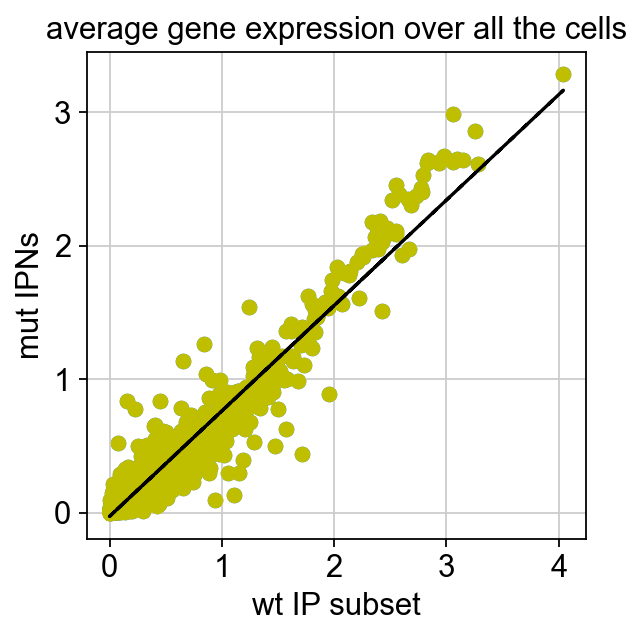

In [1058]:
x =  np.squeeze(np.asarray(terminal_state1[:, overlapping_genes].X.mean(axis = 0)))
#y = np.squeeze(np.asarray(end[:, overlapping_genes].X.mean(axis = 0)))

y = np.squeeze(np.asarray(INP_mut[:, overlapping_genes].X.mean(axis = 0)))
plt.scatter(x,y)

print(np.corrcoef(x,y))


coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 


points = np.column_stack((x, y))
points,inside_bbox = points_inside_rectangle((1,0,1,0.5), points)


plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker

plt.xlabel('wt IP subset')
plt.ylabel('mut IPNs')
plt.title('average gene expression over all the cells')
plt.savefig(path_main + '/gene_expression_mut_wt.png')




#le


list(terminal_state1[:,overlapping_genes][:,inside_bbox].var_names)



KeyError: 'Could not find key SOX4 in .var_names or .obs.columns.'

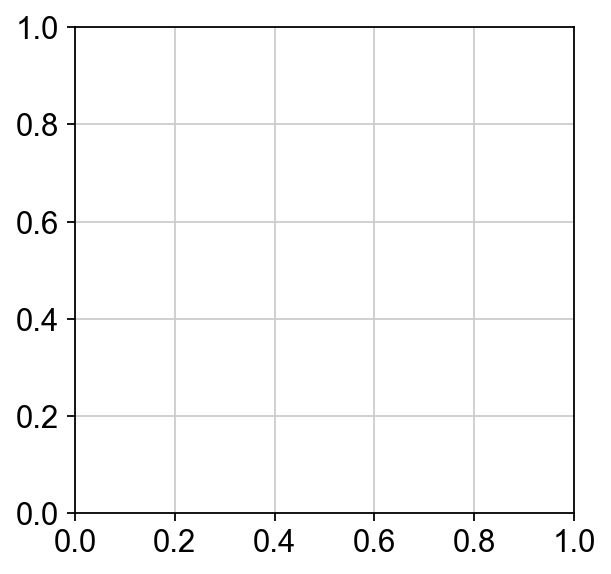

In [1005]:
 sc.pl.embedding(
        wt_all,
        basis="umap",
        color='SOX4',
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        title = zip(genes_top_vel[cond], gene_vel_dict[cond][ind]),
        save = f'top_genes_{cond}_velocity.pdf'
    )

In [ ]:
sc.pl.embedding(
        wt_all,
        basis="umap",
        color=['PAX6'],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        #title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        #save = f'top_genes_{cond}_expression_nervous_system_development.pdf'
    )

In [ ]:
from scipy import sparse

def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs

In [ ]:

corr_matrix_term_end = sparse_corrcoef(terminal_state1[:, overlapping_genes].X,end[:, overlapping_genes].X)

corr_matrix_term_INP = sparse_corrcoef(terminal_state1[:, overlapping_genes].X,INP_mut[:, overlapping_genes].X)

corr_matrix.shape


In [ ]:
correlation_cells = np.squeeze(np.asarray(corr_matrix_term_INP[:543,543:].mean(axis = 1)))




In [ ]:
plt.scatter(x = np.squeeze(np.asarray(terminal_state1[:,["PAX6"]].X.toarray())),y = correlation_cells)


In [ ]:
terminal_state1[:,["PAX6"]].X.toarray()

ran on python 3.11 with following packages
Package                 Version             Editable project location
----------------------- ------------------- --------------------------
absl-py                 2.0.0 \
aiohttp                 3.8.6 \
aiosignal               1.3.1 \
anndata                 0.10.2 \
annotated-types         0.6.0 \
anyio                   3.7.1 \
appnope                 0.1.2
array-api-compat        1.4
arrow                   1.3.0
asttokens               2.0.5
async-timeout           4.0.3
attrs                   23.1.0
backcall                0.2.0
backoff                 2.2.1
beautifulsoup4          4.12.2
blessed                 1.20.0
boltons                 23.0.0
boto3                   1.28.67
botocore                1.31.67
Brotli                  1.0.9
cellrank                2.0.1.dev7+gf3a6a0e
certifi                 2023.7.22
cffi                    1.15.1
chardet                 5.2.0
charset-normalizer      3.3.0
chex                    0.1.7
click                   8.1.7
comm                    0.1.2
conda                   23.9.0
conda-package-handling  2.2.0
conda_package_streaming 0.9.0
contextlib2             21.6.0
contourpy               1.1.1
cospar                  0.3.3
croniter                1.4.1
cryptography            41.0.3
cycler                  0.12.1
dateutils               0.6.12
debugpy                 1.6.7
decorator               5.1.1
deepdiff                6.6.1
dm-tree                 0.1.8
docrep                  0.3.2
ete3                    3.1.3
etils                   1.5.1
executing               0.8.3
fastapi                 0.104.0
fastcluster             1.2.6
filelock                3.12.4
flax                    0.7.4
fonttools               4.43.1
frozenlist              1.4.0
fsspec                  2023.9.2
gseapy                  1.0.6
h11                     0.14.0
h5py                    3.10.0
htmlmin                 0.1.12
idna                    3.4
igraph                  0.10.8
ImageHash               4.3.1
importlib-resources     6.1.0
inquirer                3.1.3
install                 1.3.5
ipykernel               6.25.2
ipython                 8.15.0
ipywidgets              8.1.1
itsdangerous            2.1.2
jax                     0.4.19
jaxlib                  0.4.19
jedi                    0.18.1
Jinja2                  3.0.3
jmespath                1.0.1
joblib                  1.1.1
jsonpatch               1.32
jsonpointer             2.1
jupyter_client          8.1.0
jupyter_core            5.3.0
jupyterlab-widgets      3.0.9
kiwisolver              1.4.5
leidenalg               0.10.1
lightning               2.0.9.post0
lightning-cloud         0.5.42
lightning-utilities     0.9.0
llvmlite                0.41.0
loompy                  3.0.7
markdown-it-py          3.0.0
MarkupSafe              2.1.3
matplotlib              3.7.0
matplotlib-inline       0.1.6
mdurl                   0.1.2
missingno               0.5.2
mizani                  0.9.3
ml-collections          0.1.1
ml-dtypes               0.3.1
mpmath                  1.3.0
msgpack                 1.0.7
mudata                  0.2.3
multidict               6.0.4
multimethod             1.10
multipledispatch        1.0.0
natsort                 8.4.0
nest-asyncio            1.5.6
networkx                3.1
numba                   0.58.1
numpy                   1.25.0
numpy-groupies          0.10.2
numpyro                 0.13.2
opt-einsum              3.3.0
optax                   0.1.7
orbax-checkpoint        0.4.1
ordered-set             4.1.0
packaging               23.1
pandas                  2.1.1
pandas-profiling        3.2.0
parso                   0.8.3
patsy                   0.5.3
petsc4py                3.19.0
pexpect                 4.8.0
phik                    0.12.3
pickleshare             0.7.5
Pillow                  10.1.0
pip                     23.3
platformdirs            3.10.0
plotnine                0.12.3
pluggy                  1.0.0
progressbar2            4.2.0
prompt-toolkit          3.0.36
protobuf                4.24.4
psutil                  5.9.0
ptyprocess              0.7.0
pure-eval               0.2.2
pycosat                 0.6.6
pycparser               2.21
pydantic                2.1.1
pydantic_core           2.4.0
pygam                   0.9.0
Pygments                2.15.1
pygpcca                 1.0.4
PyJWT                   2.8.0
pynndescent             0.5.10
pyOpenSSL               23.2.0
pyparsing               3.1.1
pyro-api                0.1.2
pyro-ppl                1.8.6
PySocks                 1.7.1
python-dateutil         2.8.2
python-editor           1.0.4
python-multipart        0.0.6
python-utils            3.8.1
pytorch-lightning       2.1.0
pytz                    2023.3.post1
PyWavelets              1.4.1
PyYAML                  6.0.1
pyzmq                   25.1.0
readchar                4.0.5
requests                2.31.0
rich                    13.6.0
ruamel.yaml             0.17.21
s3transfer              0.7.0
scanpy                  1.9.5
scikit-learn            1.1.3
scikit-misc             0.3.0
scipy                   1.11.3
scvelo                  0.3.0               /Users/samuelheczko/scvelo
scvi-tools              1.0.4
seaborn                 0.13.0
session-info            1.0.0
setuptools              68.0.0
six                     1.16.0
slepc4py                3.19.2
sniffio                 1.3.0
soupsieve               2.5
sparse                  0.14.0
stack-data              0.2.0
starlette               0.27.0
starsessions            1.3.0
statsmodels             0.14.0
stdlib-list             0.9.0
sympy                   1.12
tangled-up-in-unicode   0.2.0
tensorstore             0.1.46
texttable               1.7.0
threadpoolctl           3.2.0
toolz                   0.12.0
torch                   2.1.0
torchmetrics            1.2.0
tornado                 6.3.3
tqdm                    4.65.0
traitlets               5.7.1
truststore              0.8.0
types-python-dateutil   2.8.19.14
typing_extensions       4.8.0
tzdata                  2023.3
umap-learn              0.5.4
urllib3                 1.26.18
uvicorn                 0.23.2
visions                 0.7.4
wcwidth                 0.2.5
websocket-client        1.6.4
websockets              11.0.3
wheel                   0.41.2
widgetsnbextension      4.0.9
wrapt                   1.15.0
xarray                  2023.10.1
yarl                    1.9.2
zipp                    3.17.0
zstandard               0.19.0




it assumes following file structure

└── PAX6_code
│   └── data
│   └── notebooks
│   └── plots